In this notebook, I explore fitting community occupancy models in PyMC. Community occupancy models are a multi-species extension of standard occupancy models. The benefit of these models is that they estimate occupancy and detection better that single species models by treating each species as a random effect. Further, through data augmentation, they can estimate the richness of the supercommunity, that is, the total number of species that use the study area during the surveys.

# US Breeding Bird Survey

As a motivating example, I use the breeding bird survey (BBS) data used by @dorazio2005 and @royle2008, Chapter 12. This is a $(n, J)$ matrix with the number of times each species was detected over $K$ surveys, where $n$ is the number of detected species and $J$ is the number surveyed sites. In this example, $n=99$ species were detected at the $J=50$ sites over the $K=11$ surveys in New Hampshire. The BBS occurs on routes across the US. This dataset represents one route.

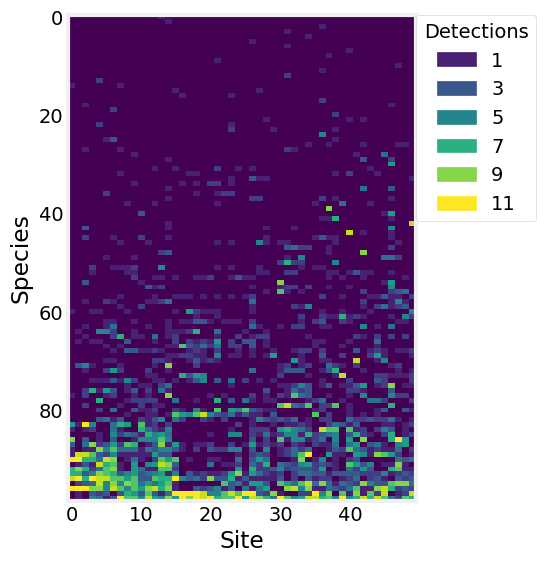

In [1]:
#| fig-cap: Number of detections for each species at each site along this BBS route.
#| label: fig-bbs

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

SEED = 808
RNG = np.random.default_rng(SEED)

plt.style.use('fivethirtyeight')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

def invlogit(x):
    return 1 / (1 + np.exp(-x))

# read in the detection data
nh17 = pd.read_csv('detectionFreq.NH17.csv')
Y = nh17.to_numpy()
n, J = Y.shape
K = Y.max()

# convert the species names to ints 
species_idx, lookup = nh17.index.factorize() # lookup[int] returns the actual name

# plot the detection frequencies
fig, ax = plt.subplots(figsize=(4, 6))
im = ax.imshow(Y[np.argsort(Y.sum(axis=1))], aspect='auto')
ax.set_ylabel('Species')
ax.set_xlabel('Site')

# add a legend
values = np.unique(Y.ravel())[1::2]
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ Patch(color=colors[i], label=f'{v}') for i, v in enumerate(values) ]
plt.legend(title='Detections', handles=patches, bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
ax.grid(False)
plt.show()

@dorazio2005 draw each species-level effect from a multivariate normal distribution,
$$
{\alpha_i \choose \beta_i} \sim \text{Normal} \left( {\mu_{\,\text{detection}} \choose \mu_{\, \text{occupancy}}}, \; \mathbf{\Sigma} \right),
$$
where $\alpha_i$ is the logit-scale probability of detection for species $i=1,\dots,n$, $\beta_i$ is the logit-scale probability of occurrence, $\mu$ is the community-level average, and $\mathbf{\Sigma}$ is the covariance matrix. We assume that there will be a positive correlation between occupancy and the probability of detection, since abundance is positively correlated with both. 

## Known $N$

First, I fit the the known $N$ version of the model. The goal of this version is to estimate occurrence and detection for each species, without estimating species richness.

This notebook makes extensive use of the `coords` feature in PyMC. `Coords` makes it easier to incorporate the species-level effects via the multivariate normal. I use a $\text{Normal}(0, 2)$ prior for both $\mu$ parameters, and a LKJ Cholesky covariance prior for $\mathbf{\Sigma}.$

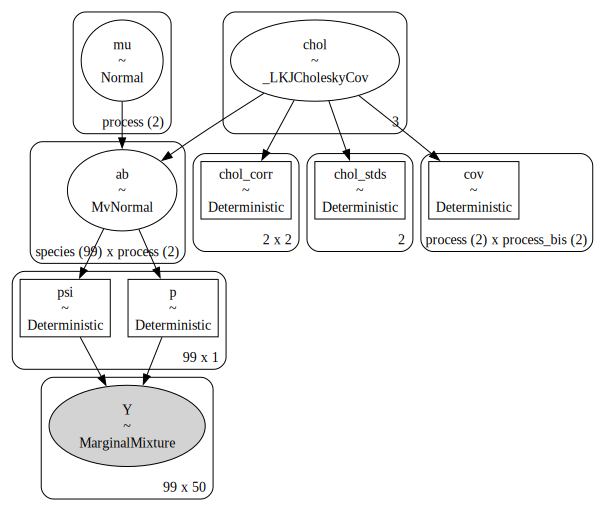

In [2]:
#| fig-cap: Visual representation of the known $N$ version of the community occupancy model. 
#| label: fig-known

coords = {'process': ['detection', 'occurrence'], 
          'process_bis': ['detection', 'occurrence'],
          'species': lookup}

with pm.Model(coords=coords) as known:

    # priors for community-level means for detection and occurrence
    mu = pm.Normal('mu', 0, 2, dims='process')

    # prior for covariance matrix for occurrence and detection
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0, shape=2)
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T), dims=("process", "process_bis"))

    # species-level occurrence and detection probabilities on logit-scale  
    ab = pm.MvNormal("ab", mu, chol=chol, dims=("species", "process"))

    # probability of detection. newaxis allows for broadcasting
    a = ab[:, 0][:, np.newaxis]
    p = pm.Deterministic("p", pm.math.invlogit(a))

    # probability of detection. newaxis allows for broadcasting
    b = ab[:, 1][:, np.newaxis]
    psi = pm.Deterministic("psi", pm.math.invlogit(b))

    # likelihood
    pm.ZeroInflatedBinomial('Y', p=p, psi=psi, n=K, observed=Y)

pm.model_to_graphviz(known)

In [3]:
with known:
    known_idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, chol, ab]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


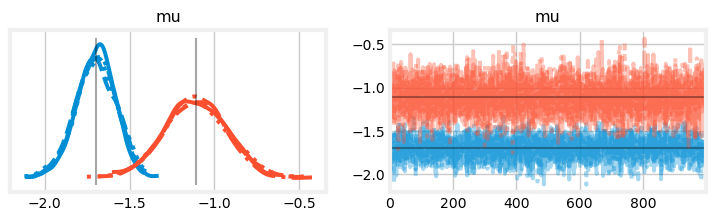

In [4]:
#| fig-cap: Trace plots for the community level means of occupancy and abundance in the known $N$ version of the BBS model. The estimates from @royle2008 are shown by vertical and horizontal lines.
#| label: fig-trace_known.
mu_hat_royle = [-1.11, -1.7]
az.plot_trace(known_idata, var_names=['mu'], figsize=(8,2),
              lines=[("mu", {}, [mu_hat_royle])]);

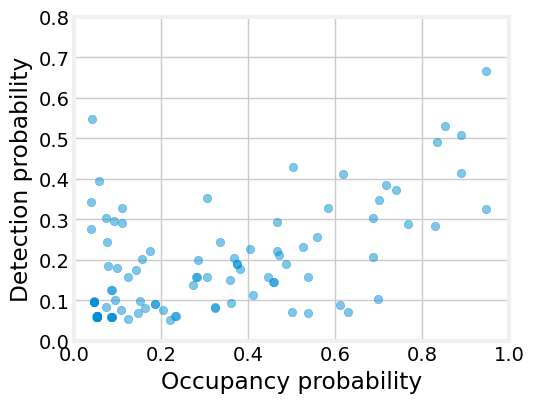

In [5]:
#| fig-cap: Species-level probabilities of detection and occupancy.
#| label: fig-probs
samps = az.extract(known_idata, var_names='ab')
ab_mean = samps.mean(axis=2)

fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(invlogit(ab_mean[:, 1]), invlogit(ab_mean[:, 0]), alpha=0.5)
ax.set_xlim((0, 1))
ax.set_xlabel('Occupancy probability')
ax.set_ylim((0, 0.8))
ax.set_ylabel('Detection probability')
plt.show()

The estimates of the community-level means is quite close to the estimates from @royle2008. We can visualize the species-level probabilities of detection and occupancy. Compare with Figure 12.3 in @royle2008.

## Unknown $N$

Next, I train the unknown $N$ version of the model. Like many other notebooks in this series, it relies on augmenting the detection histories with all-zero histories. These represent the detection histories for species that may use the study site, but were not detected over the $K=11$ surveys. I also augment the species names in the `coords` dict, such that we can still use the `dims` argument in the multivariate normal. Mirroring @royle2008, I augment the history $M - n$ all-zero histories, where $M=250$ and $n$ is the number of species detected during the survey. 

Similar to the occupancy notebook, I use a `CustomDist` to model the augmented history. This accounts for the "row-level" zero-inflation, whereby we know that the species is included in the super community if it was detected along the BBS route. The only difference with this `logp` is that it uses a `ZeroInflatedBinomial` distribution under the hood, rather than a Bernoulli, and uses the parameter $\Omega$ to account for the row-level inflation. 

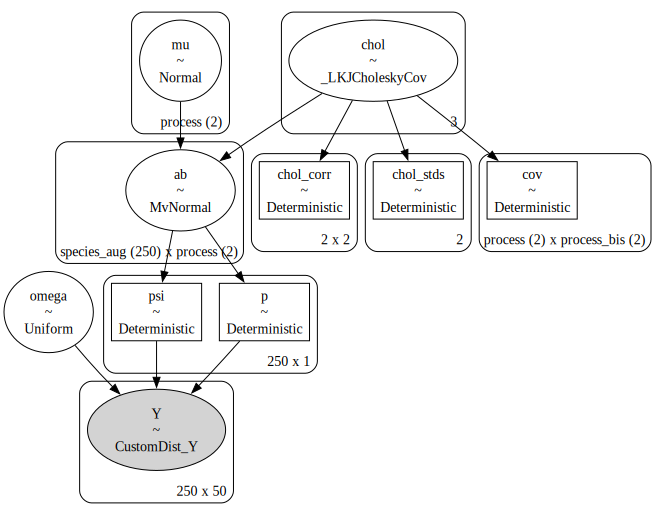

In [6]:
#| fig-cap: Visual representation of the unknown $N$ version of the BBS model.
#| label: fig-unknown
M = 250
all_zero_history = np.zeros((M - n, J))
Y_augmented = np.row_stack((Y, all_zero_history))

aug_names = [f'aug{i}' for i in np.arange(M - n)]
spp_aug = np.concatenate((lookup, aug_names))

coords = {'process': ['detection', 'occurrence'], 
          'process_bis': ['detection', 'occurrence'],
          'species_aug': spp_aug}

def logp(x, psi, n, p, omega):

    rv = pm.ZeroInflatedBinomial.dist(psi=psi, n=n, p=p)
    lp = pm.logp(rv, x)
    lp_sum = lp.sum(axis=1)
    lp_exp = pm.math.exp(lp_sum)
    
    res = pm.math.switch(
        x.sum(axis=1) > 0,
        lp_exp * omega,
        lp_exp * omega + (1 - omega)
    )
    
    return pm.math.log(res)

with pm.Model(coords=coords) as unknown:

    # priors for inclusion
    omega = pm.Uniform('omega', 0, 1)
    
    # priors for community-level means for detection and occurrence
    mu = pm.Normal('mu', 0, 2, dims='process')

    # prior for covariance matrix for occurrence and detection
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0, shape=2)
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T), dims=("process", "process_bis"))

    # species-level occurrence and detection probabilities on logit-scale  
    ab = pm.MvNormal("ab", mu, chol=chol, dims=("species_aug", "process"))

    # probability of detection
    a = ab[:, 0][:, np.newaxis]
    p = pm.Deterministic("p", pm.math.invlogit(a))

    # probability of occurrence
    b = ab[:, 1][:, np.newaxis]
    psi = pm.Deterministic("psi", pm.math.invlogit(b))

    # likelihood
    pm.CustomDist(
        'Y',
        psi,
        K,
        p,
        omega,
        logp=logp,
        observed=Y_augmented
    )
    
pm.model_to_graphviz(unknown)

In [ ]:
with unknown:
    unknown_idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega, mu, chol, ab]


In [ ]:
#| fig-cap: Trace plots for the inclusion parameter for the unknown $N$ version of the BBS model. The estimate from @royle2008 are shown by vertical and horizontal lines.
#| label: fig-trace_unknown.
omega_hat_royle = [0.55]
az.plot_trace(known_idata, var_names=['omega'], figsize=(8,2), 
              lines=[("omega", {}, [omega_hat_royle])]);

I can plot the posterior distribution of species richness $N.$ This is slightly more complicated than before sinc there is an additional level of zero-inflation (included and never detected or not-included) in this model compared to the occupancy model (present and never detection or not present). 

In [ ]:
#| fig-cap: Posterior distribution of species richness from the BBS model.
#| label: fig-postN 

# relevant posterior samples
post = az.extract(unknown_idata)
o_samps = post.omega.to_numpy()
psi_samps = post.psi.to_numpy()[n:, :]
p_samps = post.p.to_numpy()[n:, :]

# probability that the animal was never detected during the survey if present
p_not_detected = (1 - p_samps) ** K

# probability of a zero detection history 
p_zero_hist = psi_samps * p_not_detected + (1 - psi_samps)

# probability that the species was included in the given the all-zero history
p_included = (o_samps * p_zero_hist ** J) / (o_samps * p_zero_hist ** J + (1 - o_samps))

# posterior samples of N
number_undetected = RNG.binomial(1, p_included).sum(axis=0)
N_samps = n + number_undetected

# posterior distribution 
N_hat_royle = 138
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(N_samps, edgecolor='white', bins=25)
ax.set_xlabel('Species richness $N$')
ax.set_ylabel('Posterior samples')
ax.axvline(N_hat_royle, linestyle='--', color='C1')
ax.axvline(N_samps.mean(), linestyle='--', color='C2')
plt.show()

# Puerto Rican Birds

In [ ]:
c = ['STATION ID', 'Agricultural', 'ForestSource', 'Forested', 'Urbanized', 
     'SPECIES', 'Breed1-1', 'Breed1-2', 'Breed1-3', 'Breed2-1', 'Breed2-2', 'Breed2-3']

prbirds = pd.read_csv('prbirds.csv')[c]
# prbirds['Y'] = prbirds[['Breed1-1', 'Breed1-2', 'Breed1-3']]
prbirds.columns = ['site', 'ag', 'edge', 'forest', 'urban', 'species', 
                   'y1', 'y2', 'y3', 'y4', 'y5', 'y6']
prbirds = prbirds.loc[~prbirds.isna().all(axis=1)]

prbirds['landuse'] = np.where(prbirds.ag, 0,
                              np.where(prbirds.edge, 1,
                                       np.where(prbirds.forest, 2, 3)))

prbirds['species'] = pd.Categorical(prbirds.species)
prbirds['species_idx'] = prbirds.species.cat.codes
spp = prbirds.species.unique().to_numpy()

prbirds['site'] = pd.Categorical(prbirds.site)
prbirds['site_idx'] = prbirds.site.cat.codes

prbirds['Y'] = prbirds[['y1', 'y2', 'y3', 'y4', 'y5', 'y6']].sum(axis=1)

data = prbirds[['species_idx', 'site_idx', 'landuse', 'Y']]

In [ ]:
# number of detections at each site for each species
sort_order = data.loc[data.landuse==0].groupby('species_idx').Y.sum().sort_values(ascending=False).index
cells = data.pivot(index='species_idx', columns='site_idx', values='Y').loc[sort_order].to_numpy()

# plot the heat map
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(cells)

# add a legend
values = np.unique(cells.ravel())
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ Patch(color=colors[i], label=f'{i}') for i in range(len(values)) ]
plt.legend(title='Detections', handles=patches, bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

# move the x axis 
loc = data[['site_idx', 'landuse']].drop_duplicates().groupby('landuse').count().cumsum()
ax.set_xticks(loc.to_numpy().flat[:-1])
ax.xaxis.tick_top()
ax.xaxis.set_ticklabels([])

# label each landuse
ax.text(15, 0 - 1, 'Agriculture', va='bottom', ha='center', fontsize=14)
ax.text(49, 0 - 1, 'Edge', va='bottom', ha='center', fontsize=14)
ax.text(83, 0 - 1, 'Forest', va='bottom', ha='center', fontsize=14)
ax.text(113, 0 - 1, 'Urban', va='bottom', ha='center', fontsize=14)

# label each axis
ax.set_xlabel('Site', fontsize=14)
ax.set_ylabel('Species', fontsize=14)

ax.grid(False)
ax.spines.top.set_visible(True)
ax.tick_params(axis='x',length=10)
plt.show()

In [ ]:
species_idx = prbirds.species_idx.to_numpy()
landuse_idx = prbirds.landuse.to_numpy()
spp = prbirds.species.unique().to_numpy()
site = data.site_idx.to_numpy()
Y = data.Y

coords = {'landuse': ['agriculture', 'edge', 'forest', 'urban'],
          'species': spp}

with pm.Model(coords=coords) as msom:
    
    # detection process priors 
    mu_a = pm.Normal("mu_a", 0, 2)
    sigma_a = pm.Exponential("sigma_a", 1)
    alpha = pm.Normal("alpha", mu=mu_a, sigma=sigma_a, dims="species")

    # detection process priors
    p = pm.Deterministic("p", pm.math.invlogit(alpha[species_idx]))
    
    # occurrence process priors 
    mu_b = pm.Normal("mu_b", 0, 2, dims='landuse')
    sigma_b = pm.Exponential("sigma_b", 1, dims='landuse')
    beta = pm.Normal("beta", mu=mu_b, sigma=sigma_b, dims=('species', 'landuse'))

    # linear model
    psi = pm.Deterministic("psi", pm.math.invlogit(beta[species_idx, landuse_idx]))

    # likelihood
    pm.ZeroInflatedBinomial('y', p=p, psi=psi, n=K, observed=Y)

pm.model_to_graphviz(msom)

In [ ]:
with msom:
    test = pm.sample()

In [ ]:
plt.style.use('default')

def invlogit(x):
    return 1 / (1 + np.exp(-x))

betas = az.extract(test, var_names='beta')
psis = invlogit(betas)
psi_mean = psis.mean(axis=2)
interval = np.quantile(psis, [0.1, 0.9], axis=2)

fig, axs = plt.subplots(10, 5, tight_layout=True, sharey=True, sharex=True, figsize=(8, 11))
axx = axs.flatten()

for i in range(50):
    
    y = coords['landuse']
    x = psi_mean[i]
    err = interval[:,i,:]
    
    axx[i].set_title(spp[i], fontsize=10)
    axx[i].scatter(x, y, marker='.', color=['C0', 'C1', 'C2', 'C3'])
    axx[i].hlines(y, err[0], err[1], color=['C0', 'C1', 'C2', 'C3'])
    axx[i].set_xticks([0, 0.5, 1])
    axx[i].set_xticklabels(['0', '', '1'])
    axx[i].spines.top.set_visible(False)
    axx[i].spines.right.set_visible(False)
    # axx[i].grid(True, axis='x')
    
plt.show()